In [1]:
import os
import psrchive
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties import unumpy

In [ ]:
split = 8

In [22]:
template = psrchive.Archive_load("fits/template.fits")
template = template.get_data()

In [4]:
data = psrchive.Archive_load("fits/493_446.fits")
data.fscrunch()
data.unload("fits/time/493_1.fits")

Unrecognized telescope code (GMRT)


In [5]:
values = [data.get_nsubint()]
for i in range(split - 1):
    data.tscrunch(2)
    x = data.get_nsubint()
    values.append(x)
    y = data.get_nchan()
    name = f"fits/time/{x}_{y}.fits"
    data.unload(name)

print(values)

[493, 247, 124, 62, 31, 16, 8, 4]


In [25]:
arrtim = psrchive.ArrivalTime()
arrtim.set_shift_estimator("PGS")  # can change to FDM (MCMC), COF, GIS
arrtim.set_format("Tempo2")

std = psrchive.Archive_load("fits/template.fits")
arrtim.set_standard(std)

In [26]:
toas = []

for i in range(split):
    obs = psrchive.Archive_load(f"fits/time/{values[i]}_1.fits")
    arrtim.set_observation(obs)

    toa = arrtim.get_toas()
    toas.append(toa)

In [27]:
for i in range(split):
    f = open(f"tim/time/{values[i]}.tim", "w")
    f.write("FORMAT 1\n")
    for j in range(len(toas[i])):
        f.write(toas[i][j] + "\n")
f.close()

In [28]:
residuals = []

for i in range(len(values)):
    residual = []
    name = values[i]
    ! tempo2 -f J1136+1551.par tim/time/{name}.tim -residuals
    f = open("residuals.dat", "r")
    for line in f:
        residual.append([float(line.split()[1]), float(line.split()[2])])
    residuals.append(residual)

This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under conditions of GPL license.

[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  NAME
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.
************************************************* 
************************************************* 
[tempo2Util.C:396] Warning: [CLK3] no clock corrections available for clock UTC(gmrt) for MJD 58987.5
[tempo2Util.C:396] Warning: [CLK4] Trying assuming UTC = UTC(gmrt)
[tempo2Util.C:396] Warning: [CLK9] ... ok, using stated approximation 
[tempo2Util.C:396] Warning: [CLK6] Proceeding assuming UTC =  UTC(gmrt)
[t2fit.C:640] ss/fs 0 0
[t2fit.C:669] START=58987.4948452366225 FINISH = 58987.5226482377911
[TKfit.C:345] SVD nparams=1 nconst=0 ndata=493
[tempo2.C:565] Complete fit


Results for PSR B1133+16


RMS pre-fit residual = 2872.819 (us), RMS post-fit residual = 2872.819 (us)
Number of fit param

Text(0, 0.5, 'Residuals (s)')

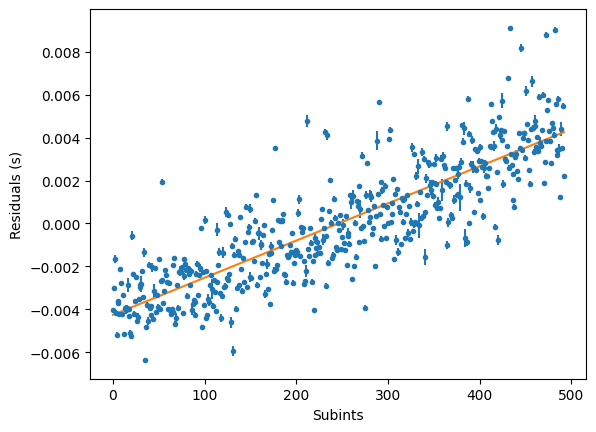

In [29]:
i = 0
xvalues = np.arange(len(residuals[i]))
yvalues = np.array(residuals[i])[:,0]
yerr = np.array(residuals[i])[:,1]

slope, intercept = np.polyfit(xvalues, yvalues, 1)
yline = intercept + slope*xvalues

plt.errorbar(xvalues, yvalues, yerr, fmt=".")
plt.plot(xvalues, yline)
plt.xlabel("Subints")
plt.ylabel("Residuals (s)")

In [30]:
valids = []

for i in range(len(residuals)):
    temp = np.array(residuals[i])
    valid = [1]*len(temp)
    timings = temp[:,0]
    
    mad = np.median(np.absolute(timings - np.median(timings)))
    # slope, intercept = np.polyfit(np.arange(len(temp)), timings, 1)
    x = np.median(timings)

    # stdev = 1.4826*MAD, 3*MAD = 2*stdev = 95% of data
    for k in range(len(timings)):
        # y = intercept + slope*k
        if abs(x-timings[k]) > 3*mad:
            valid[k] = 0
    valids.append(valid)

print([valids[i].count(1) for i in range(len(valids))])  

[487, 247, 124, 62, 31, 16, 8, 4]


In [31]:
for i in range(len(residuals)):
    temp = np.array(residuals[i])
    timings = temp[:,1]

    mad = np.median(np.absolute(timings - np.median(timings)))
    x = np.median(timings)

    # stdev = 1.4826*MAD, 4.5*MAD = 3*stdev = 99.7% of data
    for k in range(len(timings)):
        if abs(x-timings[k]) > 4.5*mad:
            valids[i][k] = 0

print([valids[i].count(1) for i in range(len(valids))])

[453, 226, 119, 55, 29, 15, 8, 4]


Text(0, 0.5, 'Residuals (s)')

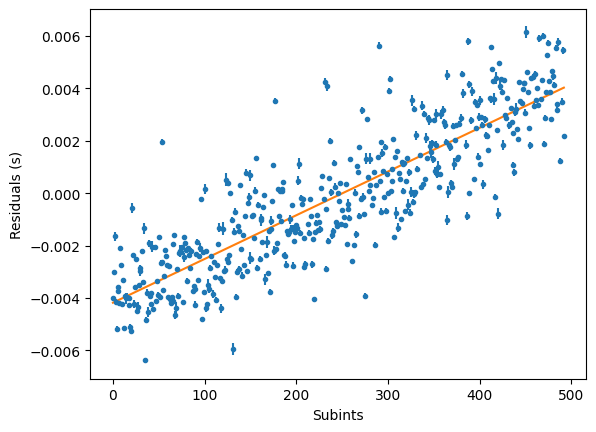

In [32]:
i = 0
tim = residuals[i]
index = [j for j in range(len(tim)) if valids[i][j] == 1]

xvalues = np.arange(len(tim))[index]
yvalues = np.array(tim)[:,0][index]
yerr = np.array(tim)[:,1][index]

slope, intercept = np.polyfit(xvalues, yvalues, 1)
yline = intercept + slope*xvalues

plt.errorbar(xvalues, yvalues, yerr, fmt=".")
plt.plot(xvalues, yline)
plt.xlabel("Subints")
plt.ylabel("Residuals (s)")

In [33]:
for i in range(split):
    f = open(f"tim/time/{values[i]}_clean.tim", "w")
    f.write("FORMAT 1\n")
    for j in range(len(toas[i])):
        if valids[i][j] == 1:
            f.write(toas[i][j] + "\n")
f.close()

In [34]:
for i in range(split):
    name = values[i]
    ! tempo2 -f J1136+1551.par tim/time/{name}_clean.tim -fit F0 -residuals
    path = f"tim/time/{name}_residuals.dat"
    os.rename("residuals.dat", path)

This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under conditions of GPL license.

[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  NAME
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.
************************************************* 
************************************************* 
[tempo2Util.C:396] Warning: [CLK3] no clock corrections available for clock UTC(gmrt) for MJD 58987.5
[tempo2Util.C:396] Warning: [CLK4] Trying assuming UTC = UTC(gmrt)
[tempo2Util.C:396] Warning: [CLK9] ... ok, using stated approximation 
[tempo2Util.C:396] Warning: [CLK6] Proceeding assuming UTC =  UTC(gmrt)
[t2fit.C:640] ss/fs 0 0
[t2fit.C:669] START=58987.4948452366225 FINISH = 58987.5226482377911
[TKfit.C:345] SVD nparams=2 nconst=0 ndata=453
[tempo2.C:565] Complete fit


Results for PSR B1133+16


RMS pre-fit residual = 2732.504 (us), RMS post-fit residual = 1373.143 (us)
Number of fit param

In [6]:
rms = []

for i in range(split):
    residual_value = []
    residual_error = []

    f = open(f"tim/time/{values[i]}_residuals.dat", "r")
    for line in f:
        line = line.split()
        residual_value.append(float(line[1]))
        residual_error.append(float(line[2]))

    residual_value = np.array(residual_value)
    residual_error = np.array(residual_error)
   
    residuals = unumpy.uarray(residual_value, residual_error)
    
    for j in range(len(residuals)):
        residuals[j] = residuals[j]**2
    
    rms.append(residuals.sum()/len(residuals))

print(rms)

[1.8855229335931954e-06+/-1.7102757543874753e-08, 9.7361664624257e-07+/-1.3444269286498852e-08, 5.172315986289896e-07+/-9.327381058691122e-09, 2.245613657506873e-07+/-5.608284802484572e-09, 1.1787167922785817e-07+/-3.8244896556052205e-09, 5.476794580576705e-08+/-2.792015794427946e-09, 4.575663560164677e-08+/-2.8292128108340184e-09, 2.237744075668739e-08+/-1.96756041389417e-09]


In [7]:
radiometer = []
for i in range(split):
    residual_error = []

    f = open(f"tim/time/{values[i]}_residuals.dat", "r")
    for line in f:
        line = line.split()
        residual_error.append(float(line[2]))

    residual_error = np.array(residual_error)
    mean = residual_error.sum()/len(residual_error)

    sum_new = 0
    for i in range(len(residual_error)):
        sum_new += (residual_error[i] - mean)**2
    sum_new /= len(residual_error)
    sum_new = sum_new**0.5
    
    x = ufloat(mean, sum_new)
    radiometer.append(x**2)

print(radiometer)

[1.0738907417937812e-08+/-1.0212300500028767e-08, 6.41806795526292e-09+/-5.264708758574775e-09, 3.550601555846055e-09+/-2.7721222748630694e-09, 1.5320221509302476e-09+/-9.043710602718917e-10, 9.457003498513675e-10+/-6.006740960615721e-10, 6.0104406244e-10+/-3.6993963739586794e-10, 3.7129436100000005e-10+/-2.192821902207886e-10, 2.883373802499999e-10+/-1.699652839485014e-10]


In [8]:
jitter = []
for i in range(split):
    x = (rms[i] - radiometer[i])**0.5
    jitter.append(x)

print(jitter)

[0.001369227529001392+/-7.274073665313901e-06, 0.0009834625454420251+/-7.340562011778209e-06, 0.0007167154226561219+/-6.788333284493549e-06, 0.0004722598263665427+/-6.01441650250669e-06, 0.00034194440904627586+/-5.660822494803355e-06, 0.00023273783908794686+/-6.050622259289067e-06, 0.00021303835626629953+/-6.660063536454044e-06, 0.00014862403364340973+/-6.643904899140604e-06]


Text(0, 0.5, 'Jitter (us)')

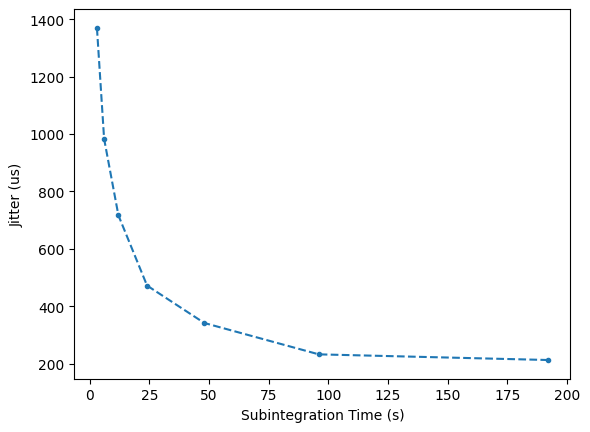

In [11]:
xvalues = [3, 6, 12, 24, 48, 96, 192, 384]
yvalues = []
yerr = []
for i in range(split):
    yvalues.append((jitter[i].nominal_value)*1e6)
    yerr.append((jitter[i].std_dev)*1e6)

f = open("tim/time/1.txt", "w")
f.write("Subint (s)       Jitter (us)        Jitter Error (us)\n")
for i in range(8):
    value = f"{xvalues[i]} {yvalues[i]} {yerr[i]} \n"
    f.write(value)
f.close()

plt.errorbar(xvalues[:-1], yvalues[:-1], yerr=yerr[:-1], fmt=".--")
plt.xlabel("Subintegration Time (s)")
plt.ylabel("Jitter (us)")